## Importing Python Libraries

In [1]:
import numpy as np
import pandas as pd
import neattext.functions as nfx
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import joblib

## Loading the Datasets and Merging them to Single Dataset

In [2]:
df1 = pd.read_csv('../Datasets/goemotions_1.csv')
df2 = pd.read_csv('../Datasets/goemotions_2.csv')
df3 = pd.read_csv('../Datasets/goemotions_3.csv')

df = pd.concat([df1,df2,df3],axis=0)
df.sample(10)

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
46348,Omg yesssss. It’s such an amazing combo,eeuolb2,tinydicktussin,benzodiazepines,t3_ajajru,t1_eeug5g8,1.548346e+09,49,False,1,...,0,0,0,0,0,0,0,0,0,0
32846,In what manner?,edzw2st,protectandservice,ProtectAndServe,t3_aflcwc,t1_edzv9nn,1.547408e+09,46,False,0,...,0,0,0,0,0,0,0,0,0,1
54072,I think a lot of it's projection. Many incels ...,eevnp85,FuzziPanda,IncelTears,t3_ajgsb0,t1_eevmj0l,1.548368e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
216,Nice of them to come check on you.,ed62jtl,knitknitterknit,My600lbLife,t3_ac8qt1,t3_ac8qt1,1.546542e+09,5,False,1,...,0,0,0,0,0,0,0,0,0,0
1753,That looks like food for a 12 year old.,edlgwyi,upinthemountains42,WeWantPlates,t3_ady3wk,t3_ady3wk,1.546991e+09,49,False,0,...,0,0,0,0,0,0,0,0,0,1
49413,Try wearing something unattractive when that s...,ee9cous,9914life,Advice,t3_agvgn9,t3_agvgn9,1.547711e+09,62,False,0,...,0,0,0,0,0,0,0,0,0,0
1999,He's eating cheese and watching football in th...,ef9u23n,TheMohawk,GreenBayPackers,t3_al0d07,t3_al0d07,1.548780e+09,3,False,0,...,0,0,0,0,0,0,0,0,0,0
3039,"I completely agree, and I love Space Jame. But...",ef8c37x,AnirudhMenon94,movies,t3_akuii7,t1_ef83abe,1.548733e+09,49,False,1,...,1,0,0,0,0,0,0,0,0,0
38803,"I'm from the UK, I thought you must have been ...",eelzgo8,WhyIsTheMoonThere,lewronggeneration,t3_ai00wi,t1_eelzdqy,1.548069e+09,61,False,1,...,0,0,0,0,1,0,0,0,0,0
67485,"""You might feel some slight discomfort""",edicuow,bejammin075,The_Mueller,t3_adk1jh,t3_adk1jh,1.546897e+09,39,False,0,...,0,0,0,0,0,0,0,0,0,1


## Listing the Emotions Columns by Type

In [3]:
positive = [
    "admiration","amusement","approval","caring","curiosity","desire","excitement",
    "gratitude","joy","love","optimism","pride","relief"
]
negative = [
    "anger","annoyance","confusion","disappointment","disapproval","disgust",
    "embarrassment","fear","grief","nervousness","remorse","sadness"
]
neutral = ["realization","surprise","neutral"]

## Assigning the Dataset Overall Emotion Labels

In [4]:
def Emotion_Labels(row) :
    if row[positive].sum() > 0 :
        return "Positive"
    elif row[negative].sum() > 0 :
        return "Negative"
    elif row[neutral].sum() > 0 :
        return "Neutral"
    else :
        return pd.NA

df['Emotions'] = df.apply(Emotion_Labels,axis=1)
df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,Emotions
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,1,0,0,Negative
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,<NA>
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,1,Neutral
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,0,0,0,0,0,0,0,0,0,Positive
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,1,Neutral


## Checking for the Null Values and Dropping them if any

In [5]:
df.isna().sum()

text                       0
id                         0
author                     0
subreddit                  0
link_id                    0
parent_id                  0
created_utc                0
rater_id                   0
example_very_unclear       0
admiration                 0
amusement                  0
anger                      0
annoyance                  0
approval                   0
caring                     0
confusion                  0
curiosity                  0
desire                     0
disappointment             0
disapproval                0
disgust                    0
embarrassment              0
excitement                 0
fear                       0
gratitude                  0
grief                      0
joy                        0
love                       0
nervousness                0
optimism                   0
pride                      0
realization                0
relief                     0
remorse                    0
sadness       

In [6]:
df.dropna(inplace=True)
df.isna().sum()

text                    0
id                      0
author                  0
subreddit               0
link_id                 0
parent_id               0
created_utc             0
rater_id                0
example_very_unclear    0
admiration              0
amusement               0
anger                   0
annoyance               0
approval                0
caring                  0
confusion               0
curiosity               0
desire                  0
disappointment          0
disapproval             0
disgust                 0
embarrassment           0
excitement              0
fear                    0
gratitude               0
grief                   0
joy                     0
love                    0
nervousness             0
optimism                0
pride                   0
realization             0
relief                  0
remorse                 0
sadness                 0
surprise                0
neutral                 0
Emotions                0
dtype: int64

## Finding out the Value Counts of Emotions in the Dataset

In [7]:
df['Emotions'].value_counts()

Emotions
Positive    90895
Neutral     63706
Negative    53213
Name: count, dtype: int64

## Preparing the Dataset for Training and Testing

In [8]:
dff = pd.DataFrame()
dff['Text'] = (df['text'].astype(str) +
    ' | Author: ' + df['author'].astype(str) +
    ' | Subreddit: ' + df['subreddit'].astype(str)
)
dff['Emotions'] = df['Emotions']
dff.head()

,Text,Emotions
0,That game hurt. | Author: Brdd9 | Subreddit: nrl,Negative
2,"You do right, if you don't care then fuck 'em!...",Neutral
3,Man I love reddit. | Author: MrsRobertshaw | S...,Positive
4,"[NAME] was nowhere near them, he was by the Fa...",Neutral
5,Right? Considering it’s such an important docu...,Positive


In [9]:
del df1,df2,df3,df

## Cleaning the Text

In [10]:
def clean(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\br/\w+', '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r'[{}\[\]()\|:\"\']', ' ', text)
    text = re.sub(r'[“”‘’]', ' ', text)            
    text = re.sub(r'\|{2,}', ' ', text)              
    text = nfx.remove_emails(text)
    text = nfx.remove_stopwords(text)
    text = nfx.remove_urls(text)
    text = nfx.remove_userhandles(text)
    text = nfx.remove_phone_numbers(text)
    text = nfx.remove_emojis(text)
    text = nfx.remove_puncts(text)
    text = nfx.remove_multiple_spaces(text)
    text = re.sub(r'[^a-z0-9 ]', ' ', text)           
    text = re.sub(r'\s{2,}', ' ', text)              
    return text.strip()

dff['Text'] = dff['Text'].apply(clean)
dff.head()

,Text,Emotions
0,game hurt author brdd9 subreddit nrl,Negative
2,right care fuck em author labalool subreddit c...,Neutral
3,man love reddit author mrsrobertshaw subreddit...,Positive
4,near them falcon author americanfascist713 sub...,Neutral
5,right considering important document know damn...,Positive


## Splitting the Dataset into Training and Testing Sets

In [11]:
x = dff['Text']
y = dff['Emotions']

In [12]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

## Shape of the Training and Testing Sets

In [13]:
print('X-Train Shape :')
x_train.shape

X-Train Shape :


(166251,)

In [14]:
print('Y-Train Shape :')
y_train.shape

Y-Train Shape :


(166251,)

In [15]:
print('X-Test Shape :')
x_test.shape

X-Test Shape :


(41563,)

In [16]:
print('Y-Test Shape :')
y_test.shape

Y-Test Shape :


(41563,)

## Creation of the Pipeline

#### Logistic Regression Pipeline

In [17]:
log_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.5, stop_words='english')),
    ('clf', LogisticRegression(C=1, penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=300, random_state=42))
])

#### XGBoost Pipeline

In [18]:
xgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=5, stop_words='english')),
    ('clf', XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1,
                         objective='multi:softmax', eval_metric='mlogloss',
                         use_label_encoder=False, random_state=42))
])

#### LightGBM Pipeline

In [19]:
lgbm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=5, stop_words='english')),
    ('clf', LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.1,
                         class_weight='balanced', random_state=42))
])

## Training the Models

#### Logistic Regression Model Training

In [20]:
log_pipe.fit(x_train,y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


#### XGBoost Model Training

In [21]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

xgb_pipe.fit(x_train,y_train_encoded)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


#### LightGBM Training

In [22]:
lgbm_pipe.fit(x_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.950206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298333
[LightGBM] [Info] Number of data points in the train set: 166251, number of used features: 9226
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


## Predicting the Outcomes

#### Logistic Regression Outcome

In [23]:
log_pred = log_pipe.predict(x_test)

#### XGBoost Outcome

In [24]:
y_pred_encoded = xgb_pipe.predict(x_test)
xgb_pred = le.inverse_transform(y_pred_encoded)

#### LightGBM Outcome

In [25]:
lgbm_pred = lgbm_pipe.predict(x_test)

## Model Evaluation

#### Logistic Regression

In [26]:
print("Logistic Regression :")
print(f'Accuracy Score : {accuracy_score(y_test,log_pred,)}')
print(f'Precision Score (macro): {precision_score(y_test, log_pred, average="macro")}')
print(f'Recall Score (macro): {recall_score(y_test, log_pred, average="macro")}')
print(f'F1 Score (macro): {f1_score(y_test, log_pred, average="macro")}')

Logistic Regression :
Accuracy Score : 0.6146332074200611
Precision Score (macro): 0.6098536823072259
Recall Score (macro): 0.6120757762580943
F1 Score (macro): 0.6071218089757264


#### XGBoost Classifier

In [27]:
print("XGBoost :")
print(f'Accuracy Score : {accuracy_score(y_test,xgb_pred)}')
print(f'Precision Score (macro): {precision_score(y_test, xgb_pred, average="macro")}')
print(f'Recall Score (macro): {recall_score(y_test, xgb_pred, average="macro")}')
print(f'F1 Score (macro): {f1_score(y_test, xgb_pred, average="macro")}')

XGBoost :
Accuracy Score : 0.5895628323268292
Precision Score (macro): 0.6128756382249388
Recall Score (macro): 0.5707905656047393
F1 Score (macro): 0.5681219975084235


#### LightGBM Classifier

In [28]:
print("LightGBM :")
print(f'Accuracy Score : {accuracy_score(y_test,lgbm_pred)}')
print(f'Precision Score (macro): {precision_score(y_test, lgbm_pred, average="macro")}')
print(f'Recall Score (macro): {recall_score(y_test, lgbm_pred, average="macro")}')
print(f'F1 Score (macro): {f1_score(y_test, lgbm_pred, average="macro")}')

LightGBM :
Accuracy Score : 0.5870846666506268
Precision Score (macro): 0.6127736003398941
Recall Score (macro): 0.5834848049130844
F1 Score (macro): 0.5780763288192136


## Visualizing the Confusion Matrix of Three Models

In [29]:
models = {
    'Logistic Regression': log_pred,
    'XGBoost': xgb_pred,
    'LightGBM': lgbm_pred
}
cmaps = {
    'Logistic Regression': 'Reds',
    'XGBoost': 'Blues',
    'LightGBM': 'Greens'
}
labels = le.classes_ if 'le' in locals() else np.unique(y_test)

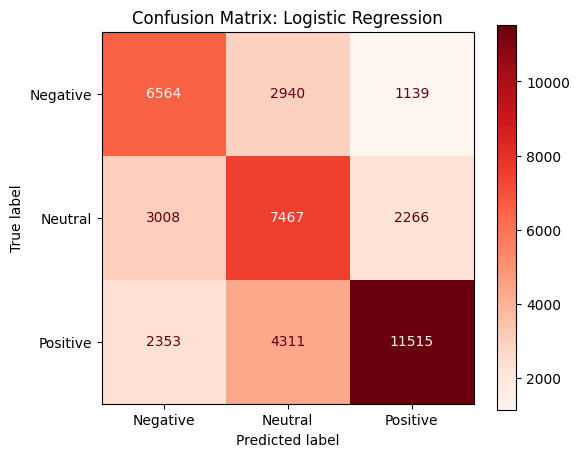

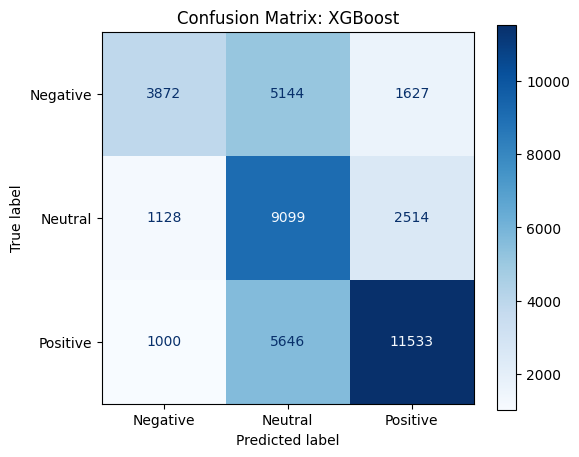

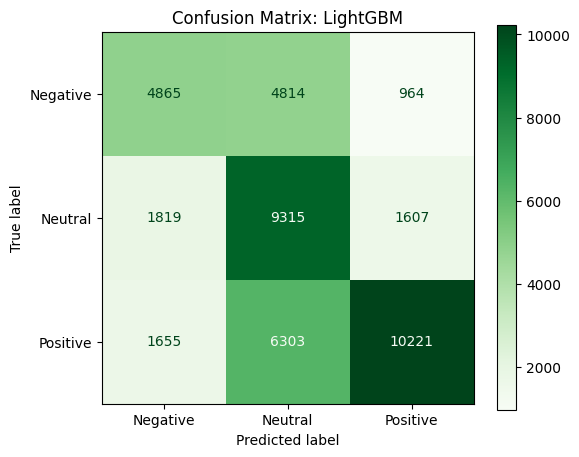

In [30]:
for i, (name, preds) in enumerate(models.items()):
    cm = confusion_matrix(y_test, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(cmap=cmaps[name], ax=ax, values_format='d')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

## Comparing the Evaluation Metrics of the Models

In [31]:
metric_dict = {}
for name, preds in models.items():
    metric_dict[name] = {
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, average='macro'),
        'Recall': recall_score(y_test, preds, average='macro'),
        'F1': f1_score(y_test, preds, average='macro')
    }

metrics_df = pd.DataFrame(metric_dict).T
metrics_df

,Accuracy,Precision,Recall,F1
Logistic Regression,0.614633,0.609854,0.612076,0.607122
XGBoost,0.589563,0.612876,0.570791,0.568122
LightGBM,0.587085,0.612774,0.583485,0.578076
